In [1]:
from pprint import pprint
import requests
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# discos_df = pd.read_pickle('unfilt_discos_data.pkl') # only those with satnos
discos_df = pd.read_pickle('discos_df.pkl') # only those with satnos
tle_df = pd.read_pickle('tle_df.pkl')

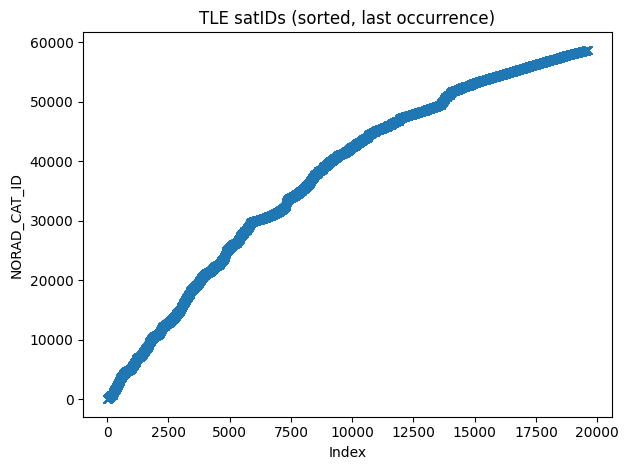

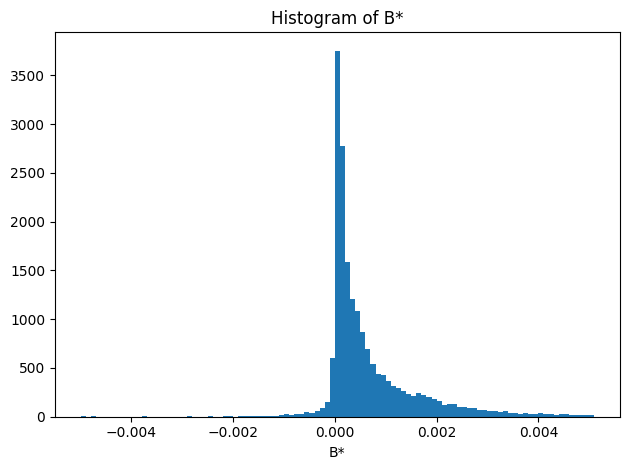

In [49]:
# 1) Scatter of NORAD IDs
tle_last = tle_df.drop_duplicates(subset='NORAD_CAT_ID', keep='last')
satIDs_sorted = np.sort(tle_last['NORAD_CAT_ID'].values)
plt.figure()
plt.plot(satIDs_sorted, 'x')
plt.xlabel('Index')
plt.ylabel('NORAD_CAT_ID')
plt.title('TLE satIDs (sorted, last occurrence)')
plt.tight_layout()
plt.show()

# 2) Histogram of B*
bstar = tle_df['BSTAR'].values
bins = np.arange(-0.005, 0.005 + 0.0001, 0.0001)
plt.figure()
plt.hist(bstar, bins=bins, edgecolor='none')
plt.xlabel('B*')
plt.title('Histogram of B*')
plt.tight_layout()
plt.show()


In [50]:
print(f"DISCOS data number of objects: {len(discos_df)}")
print("DISCOS data headers:")
print(discos_df.columns.tolist())

DISCOS data number of objects: 52159
DISCOS data headers:
['cosparId', 'vimpelId', 'satno', 'name', 'objectClass', 'mass', 'shape', 'width', 'height', 'depth', 'diameter', 'span', 'xSectMax', 'xSectMin', 'xSectAvg', 'firstEpoch', 'mission', 'predDecayDate', 'active', 'cataloguedFragments', 'onOrbitCataloguedFragments']


In [51]:
print("objectClass value counts:")
print(discos_df['objectClass'].value_counts(dropna=False))


objectClass value counts:
objectClass
Payload                           15636
Payload Fragmentation Debris      13274
Rocket Fragmentation Debris        9278
Rocket Body                        5544
Payload Mission Related Object     3938
Rocket Mission Related Object      3785
Unknown                             256
Payload Debris                      230
Rocket Debris                       176
Other Mission Related Object         31
Other Debris                         11
Name: count, dtype: int64


In [52]:
attrs_df = discos_df.copy()

# Filter to only rows with a NORAD ID (‘satno’)
has_satno = attrs_df['satno'].notna()
print(f"{has_satno.sum()} / {len(attrs_df)} DISCOS data has NORAD satellite number "
      f"({has_satno.sum()/len(attrs_df)*100:.1f}%)")
print(f"Removing {len(attrs_df) - has_satno.sum()} DISCOS objects without NORAD IDs")
attrs_df = attrs_df[has_satno].copy()

attrs_df['satno'] = attrs_df['satno'].astype(int)

# ——— Identify & drop duplicates (keep first) ———
num_before = len(attrs_df)
attrs_df = attrs_df.drop_duplicates(subset=['satno'], keep='first').reset_index(drop=True)
num_after = len(attrs_df)
print(f"{num_before - num_after} duplicate entries found in DISCOS data; removing...")

clean_discos_df = attrs_df


52158 / 52159 DISCOS data has NORAD satellite number (100.0%)
Removing 1 DISCOS objects without NORAD IDs
0 duplicate entries found in DISCOS data; removing...


In [53]:
# print("objectClass value counts:")
# print(clean_discos_df['objectClass'].value_counts(dropna=False))

TLE objects unique satIDs: 19607
6094 of 19607 (31.1%) TLE objects missing from DISCOS
13513 objects common to TLE and DISCOS
Percentage of common objects with each attribute:
	xSectAvg:  59.5%
	diameter:  11.6%
	    span:  58.4%
	   width:  47.9%
	   depth:  47.8%
	  height:  59.4%
	    mass:  59.7%
Without any size info: 40.3%
Without size NOR mass: 40.1%


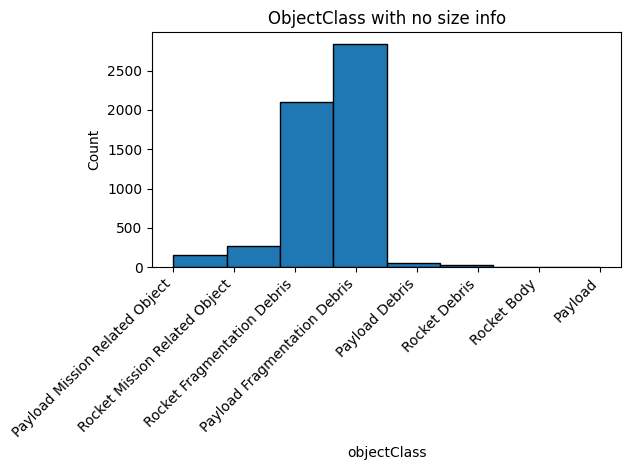

Final missingSatnos count: 12186


In [54]:
# unique TLE satIDs
satIDs = tle_df['NORAD_CAT_ID'].unique()
print(f"TLE objects unique satIDs: {len(satIDs)}")

# 2) DISCOS satnos
ddsatnos = clean_discos_df['satno'].values

# 3) Which TLE IDs are missing in DISCOS?
missingSatnos = [sid for sid in satIDs if sid not in ddsatnos]
print(f"{len(missingSatnos)} of {len(satIDs)} ({len(missingSatnos)/len(satIDs)*100:.1f}%) TLE objects missing from DISCOS")

# 4) Intersection for stats
common = np.intersect1d(satIDs, ddsatnos)
print(f"{len(common)} objects common to TLE and DISCOS")

# 5) Attribute‐presence masks
fields = ['xSectAvg','diameter','span','width','depth','height','mass']
masks = {}
disco_idx = clean_discos_df.set_index('satno')
for f in fields:
    if f in clean_discos_df.columns:
        masks[f] = disco_idx.loc[common, f].notna()
    else:
        masks[f] = pd.Series(False, index=common)

print("Percentage of common objects with each attribute:")
for f in fields:
    print(f"\t{f:>8s}: {masks[f].sum()/len(common)*100:5.1f}%")

no_size = ~(masks['xSectAvg'] | masks['diameter'] | masks['span'] |
            masks['width']  | masks['depth']    | masks['height'])
print(f"Without any size info: {no_size.sum()/len(common)*100:.1f}%")
print(f"Without size NOR mass: {(no_size & ~masks['mass']).sum()/len(common)*100:.1f}%")

# 6) Histogram of objectClass for those without size info
if 'objectClass' in clean_discos_df.columns:
    oc = disco_idx.loc[common, 'objectClass']
    bad_oc = oc[no_size].dropna()
    plt.figure()
    plt.hist(bad_oc, bins=len(bad_oc.unique()), edgecolor='k')
    plt.title('ObjectClass with no size info')
    plt.xlabel('objectClass')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # so nothing gets cut off
    plt.show()

# 7) Build dmass, dradius, dobj arrays
dmass   = np.zeros(len(satIDs))
dradius = np.zeros(len(satIDs))
dobj    = np.full(len(satIDs), np.nan)

# map objectClass to int (adjust as needed)
# 1) find all the unique class‐names
classes = clean_discos_df['objectClass'].dropna().unique()
# 2) build a string→int and int→string map
obj2int   = {cls: i+1 for i, cls in enumerate(classes)}
obj_labels = {i+1: cls for i, cls in enumerate(classes)}

for i, sid in enumerate(satIDs):
    if sid in disco_idx.index:
        row = disco_idx.loc[sid]
        if pd.notna(row.get('mass')):
            dmass[i] = row['mass']
        if pd.notna(row.get('xSectAvg')):
            dradius[i] = np.sqrt(row['xSectAvg']/np.pi)
        if pd.notna(row.get('objectClass')):
            dobj[i] = obj2int.get(row['objectClass'], np.nan)
    elif sid in (53239, 54216):
        dobj[i] = 1   # special‐case payloads
    else:
        missingSatnos.append(sid)

print(f"Final missingSatnos count: {len(missingSatnos)}")


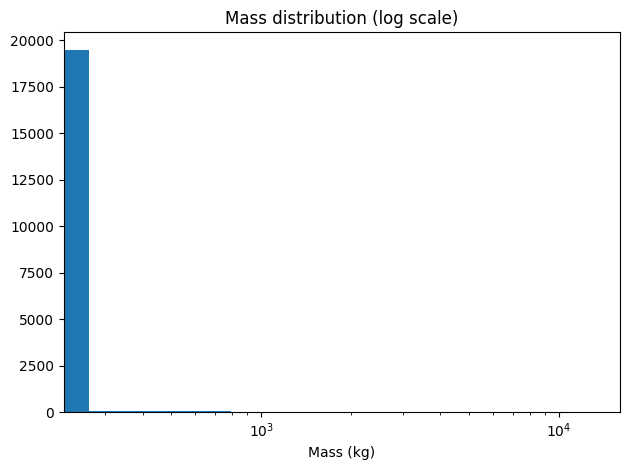

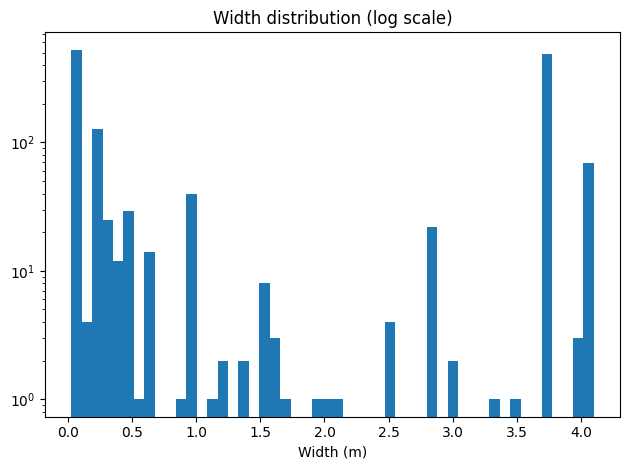

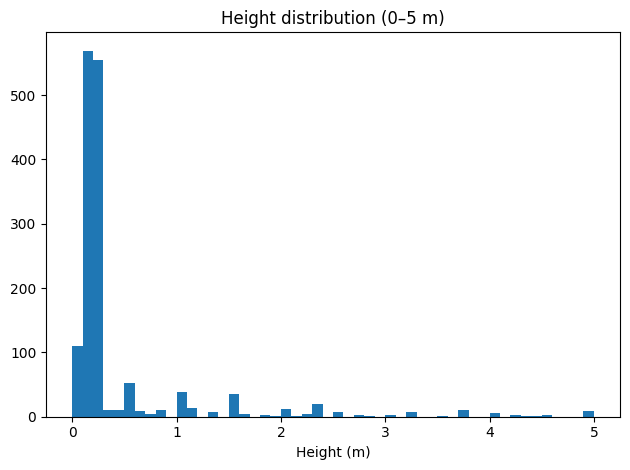

In [40]:
# — MASS histogram (log‐x) —
plt.figure()
plt.hist(dmass, bins=50, edgecolor='none')
plt.xlabel('Mass (kg)')
plt.xscale('log')
plt.title('Mass distribution (log scale)')
plt.tight_layout()
plt.show()

# — WIDTH histogram (log‐y) —
widths = clean_discos_df['width'].dropna().values
plt.figure()
plt.hist(widths, bins=50, edgecolor='none')
plt.xlabel('Width (m)')
plt.yscale('log')
plt.title('Width distribution (log scale)')
plt.tight_layout()
plt.show()

# — ZOOMED‐IN HEIGHT histogram (0–5 m bins of 0.1) —
heights = clean_discos_df['height'].dropna().values
bins = np.arange(0, 5.1, 0.1)
plt.figure()
plt.hist(heights, bins=bins, edgecolor='none')
plt.xlabel('Height (m)')
plt.title('Height distribution (0–5 m)')
plt.tight_layout()
plt.show()


In [55]:
radiusearthkm = 6378.137


# —– Extract TLE columns –––
# (make sure these exact column names exist in tle_df)
a       = tle_df['SEMIMAJOR_AXIS'].to_numpy() / radiusearthkm
ecc     = tle_df['ECCENTRICITY'].to_numpy()
incl    = np.deg2rad(tle_df['INCLINATION'].to_numpy())
nodeo   = np.deg2rad(tle_df['MEAN_ANOMALY'].to_numpy())       # MATLAB used MEAN_ANOMALY here
argpo   = np.deg2rad(tle_df['ARG_OF_PERICENTER'].to_numpy())
mo      = np.deg2rad(tle_df['MEAN_ANOMALY'].to_numpy())
bstar   = tle_df['BSTAR'].to_numpy()

# —– Prepare zeros & NaNs –––
n  = len(tle_df)
zs = np.zeros(n)
ns = np.full(n, np.nan)

# —– Convert launch date to Julian date –––
# MATLAB juliandate ≈ Unix‐epoch‐based JD:
ld = pd.to_datetime(tle_df['LAUNCH_DATE'], errors='coerce')
# convert to seconds since 1970-01-01, then to JD
jd = ld.view('int64')/1e9/86400 + 2440587.5

# —– Stack into an (n × 24) array —––
# Column order matches your MATLAB code:
# 1 a, 2 ecc, 3 incl, 4 nodeo, 5 argpo, 6 mo,
# 7 bstar, 8 dmass, 9 dradius,
# 10–15 zeros & nans,
# 16 jd, 17–19 zeros,
# 20–22 zeros, 23 dobj, 24 NORAD_CAT_ID
matsatsout = np.column_stack([
    a, ecc, incl, nodeo, argpo, mo,
    bstar, dmass, dradius,
    zs, zs, zs, zs, zs, ns,
    jd, zs, zs, zs,
    zs, zs, zs,
    dobj,
    tle_df['NORAD_CAT_ID'].to_numpy(),
])

# —– Optional: define the same idx constants —––
idx_a           = 0
idx_ecco        = 1
idx_inclo       = 2
idx_nodeo       = 3
idx_argpo       = 4
idx_mo          = 5
idx_bstar       = 6
idx_mass        = 7
idx_radius      = 8
idx_error       = 9
idx_controlled  = 10
idx_a_desired   = 11
idx_missionlife = 12
idx_constel     = 13
idx_date_created= 14
idx_launch_date = 15
idx_r           = (16,17,18)
idx_v           = (19,20,21)
idx_objectclass = 22
idx_ID          = 23

# —– Final result —
mat_sats = matsatsout


In [56]:
# all unique class names in your cleaned DISCOS data
classes = clean_discos_df['objectClass'].dropna().unique()
print(classes)
print(len(classes), "object classes in DISCOS data")

# obj_labels = {i+1: cls for i, cls in enumerate(classes)}

['Payload' 'Rocket Fragmentation Debris' 'Payload Fragmentation Debris'
 'Rocket Body' 'Rocket Mission Related Object' 'Rocket Debris'
 'Payload Mission Related Object' 'Unknown' 'Other Mission Related Object'
 'Payload Debris' 'Other Debris']
11 object classes in DISCOS data


/var/folders/9y/hnc2c1bs54b27pqfzbnxv55r0000gn/T/ipykernel_53142/857396728.py:3: RuntimeWarning: invalid value encountered in cast
  classes = mat_sats[:, idx_objectclass].astype(int)


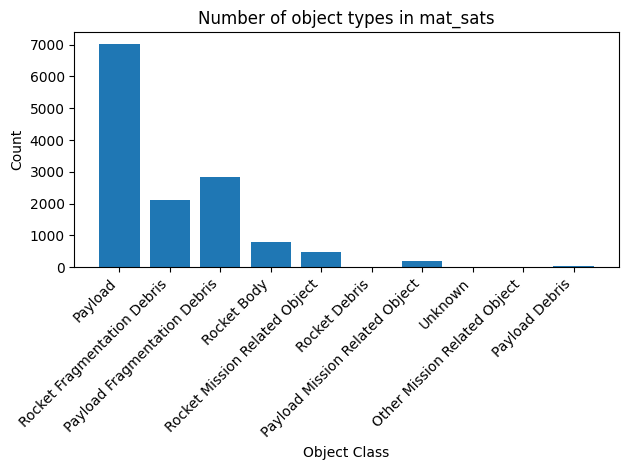

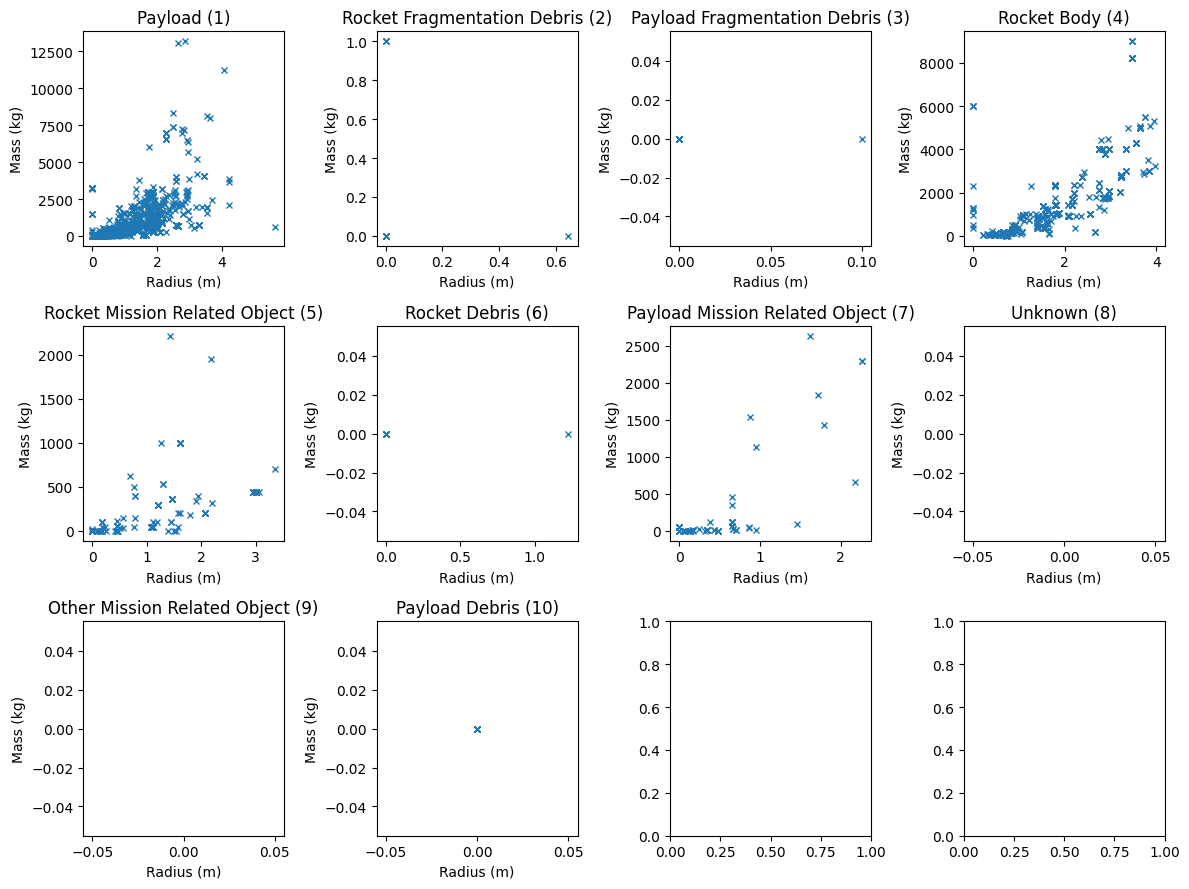

In [58]:
# 1) Histogram of object‐class counts (classes 1–11)
plt.figure()
classes = mat_sats[:, idx_objectclass].astype(int)
bins = np.arange(1, 12)  # edges at 1,2,...,12
plt.hist(classes, bins=bins, align='left', rwidth=0.8)
plt.xticks(
    np.arange(1, 11),
    [obj_labels[i] for i in range(1, 11)],
    rotation=45,
    ha='right'
)
plt.title('Number of object types in mat_sats')
plt.xlabel('Object Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 2) Scatter of radius vs mass, one subplot per class
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for ii in range(1, 11):
    ax = axes[ii-1]
    mask = mat_sats[:, idx_objectclass] == ii
    ax.plot(
        mat_sats[mask, idx_radius],
        mat_sats[mask, idx_mass],
        'x',
        markersize=4
    )
    label = obj_labels.get(ii, f'Class {ii}')
    ax.set_title(f'{label} ({ii})')
    ax.set_xlabel('Radius (m)')
    ax.set_ylabel('Mass (kg)')

# if len(axes) > 10:
    # axes[-1].axis('off')

fig.tight_layout()
plt.show()
